last version with 5 years exposures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils, boxplot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

# Loading the trained VAE

In [3]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [4]:
vae_lsst_r_band_conv, vae_r_utils, encoder_R, Dkl = utils.load_vae_conv_2('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True) # v21/bis_bis

Instructions for updating:
Colocations handled automatically by placer.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f083c96d6a0> and <tensorflow.python.keras.layers.core.Flatten object at 0x7f083c9b0a20>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f083c908dd8> and <tensorflow.python.keras.layers.core.Dense object at 0x7f083c96d6a0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f083c96d5c0> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f083c908dd8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f083c8d24a8> and <tensorflow.python.keras.layers.core.Dense object at 0x7f083c96d5c0>).


In [21]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v18/bis_bis_bis/mse/',6, folder= True) 

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v18/bis_bis/mse/',10, folder = True)

Instructions for updating:
Colocations handled automatically by placer.


# Load data

In [3]:
data_dir = "/sps/lsst/users/barcelin/data/isolated_galaxies/centered/test/"
root = 'galaxies_isolated_20191024'

In [4]:
images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [5]:
test_sample = [data_dir+'galaxies_isolated_20191024_0_images.npy']

In [6]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

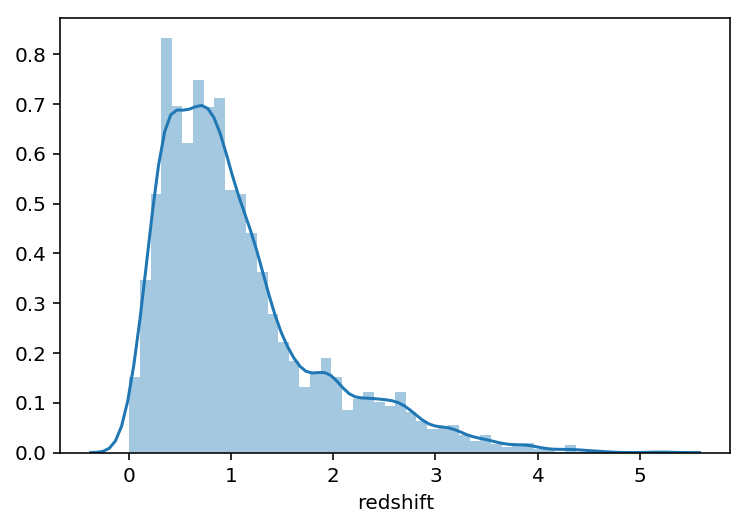

In [7]:
sns.distplot(df['redshift'])

In [9]:
df['e_in']= np.sqrt(df['e1']**2+df['e2']**2)

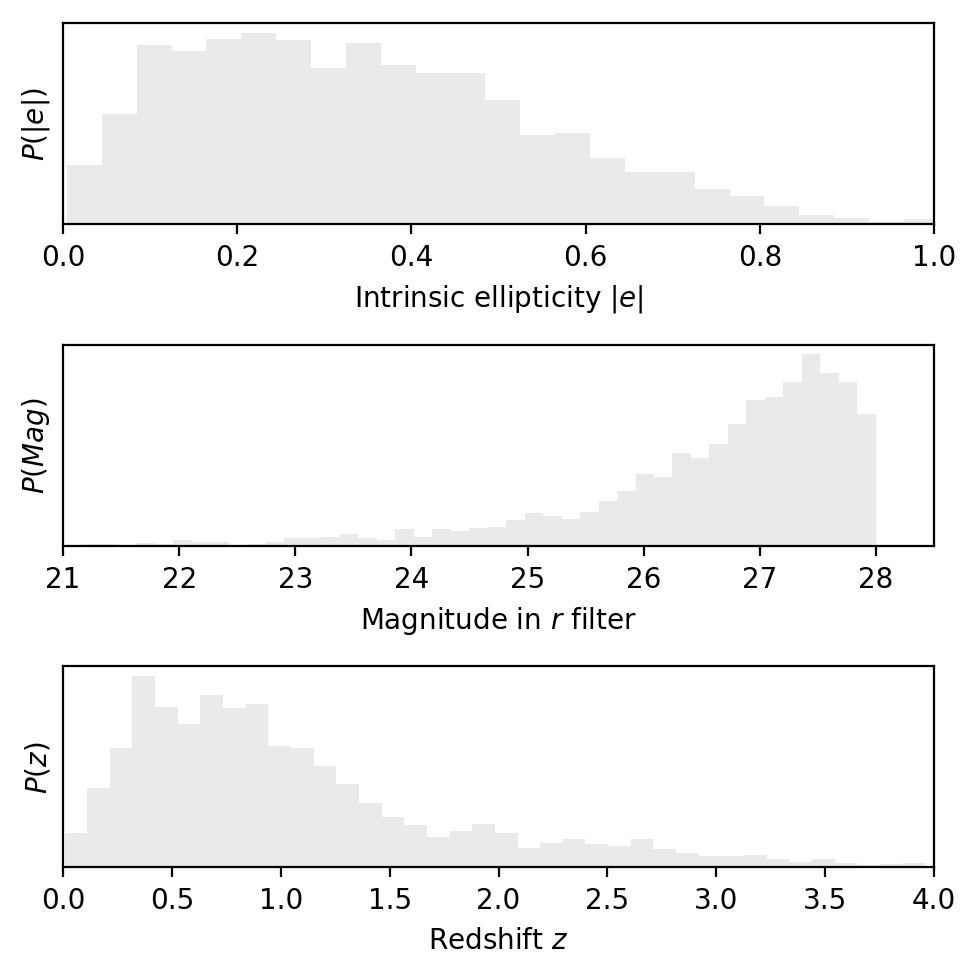

In [10]:
import matplotlib as mpl
mpl.rcdefaults()


fig, axes = plt.subplots(3, 1, figsize=(5,5), gridspec_kw={'height_ratios': [1,1,1]})

xlim = (0,1.)
sns.distplot(df['e_in'], ax=axes[0], color='0.8', kde = False)
axes[0].set_xlim(xlim[0], xlim[1])
axes[0].set_ylabel('$P(|e|$)', fontsize = 10)
axes[0].set_yticks([])
axes[0].set_xlabel('Intrinsic ellipticity $|e|$')

xlim = (21,28.5)
sns.distplot(df['mag'], ax=axes[1], color='0.8', kde = False)
axes[1].set_xlim(xlim[0], xlim[1])
axes[1].set_ylabel('$P(Mag)$', fontsize = 10)
axes[1].set_yticks([])
axes[1].set_xlabel('Magnitude in $r$ filter')

xlim = (0,4)
sns.distplot(df['redshift'], ax=axes[2], color='0.8', kde = False)
axes[2].set_xlim(xlim[0], xlim[1])
axes[2].set_ylabel('$P(z)$', fontsize = 10)
axes[2].set_yticks([])
axes[2].set_xlabel('Redshift $z$')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.6)

fig.savefig('figures/param_distrib_2.pdf', dpi = 300)

27.999769667522912

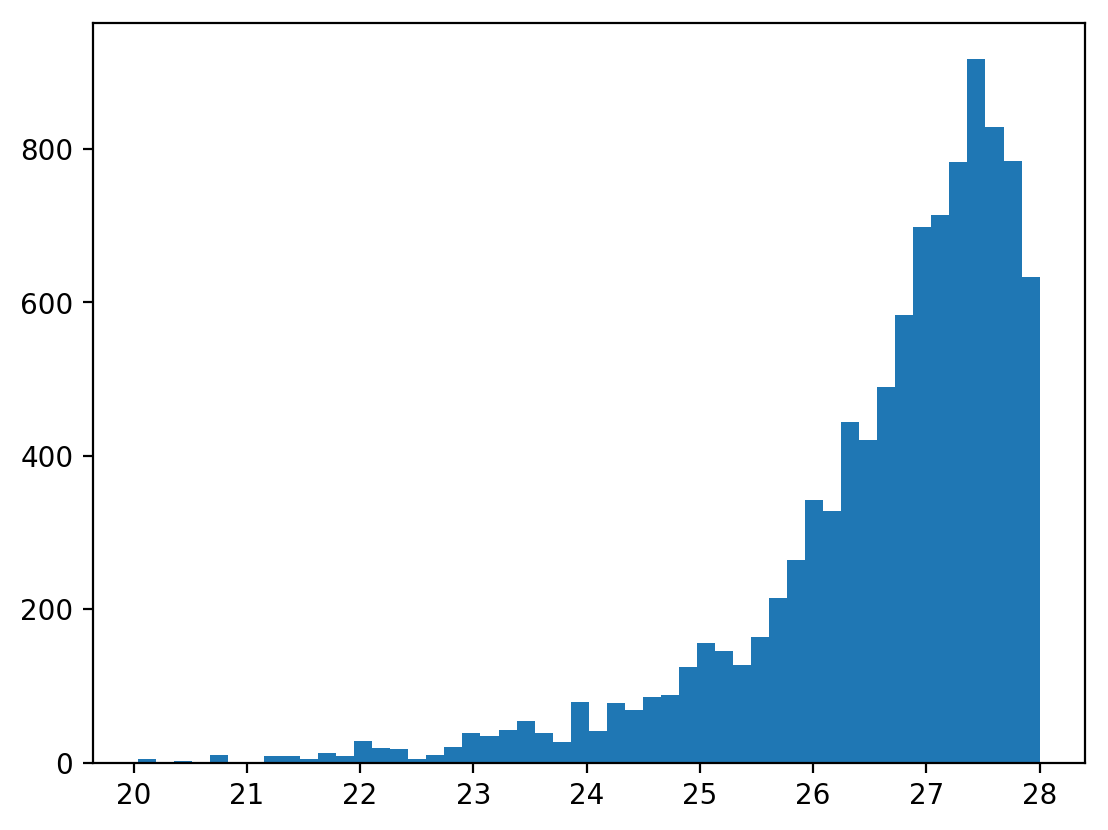

In [13]:
_ = plt.hist(df['mag'], bins = 50)
np.max(df['mag'])

# Parameters to fix

In [7]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

bands_r = [6]
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

n_years = 5

In [8]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

# VAE LSST R band

Test of data processing functions

In [12]:
N = 100
batch_size = 100

ellipticities_r_band, e_beta_r, flux_in_r, flux_out_r= results_processing.VAE_processing(vae_lsst_r_band_conv, 
                                                                                        test_sample[0],
                                                                                        bands_r,
                                                                                        0,
                                                                                        stamp_size, 
                                                                                        N, 
                                                                                        batch_size, 
                                                                                        PSF, 
                                                                                        pix_scale_lsst)

NameError: name 'vae_lsst_r_band_conv' is not defined

In [46]:
errors_r = [54,]

In [48]:
e_out_r = np.sqrt(ellipticities_r_band[:,1,0]**2+ellipticities_r_band[:,1,1]**2)
e_in_r = np.sqrt(ellipticities_r_band[:,0,0]**2+ellipticities_r_band[:,0,1]**2)
delta_e_r = e_out_r - e_in_r 

delta_e_beta = e_beta_r[:,1,0]- e_beta_r[:,0,0]

delta_e1_r = ellipticities_r_band[:,1,0]- ellipticities_r_band[:,0,0]
delta_e2_r = ellipticities_r_band[:,1,1]- ellipticities_r_band[:,0,1]

delta_mag_r = -2.5*np.log10(flux_out_r/flux_in_r)

NameError: name 'ellipticities_r_band' is not defined

## Shape plots

In [16]:
df_plot = {}

df_plot['e1_in'] = ellipticities_r_band[:,0,0]
df_plot['e1_out'] = ellipticities_r_band[:,1,0]

df_plot['e2_in'] = ellipticities_r_band[:,0,1]
df_plot['e2_out'] = ellipticities_r_band[:,1,1]

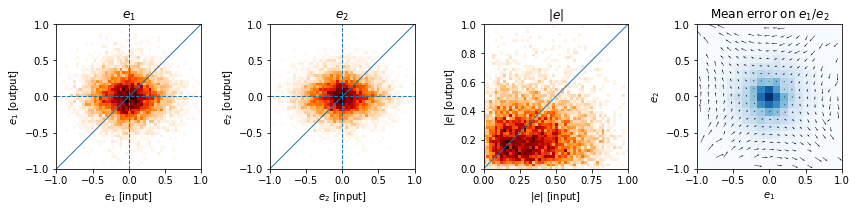

In [17]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')


ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

## LSST all filters

In [24]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [25]:
df_lsst = results_processing.processing(vae_lsst_conv,
                                         data_dir,                                           
                                         root,
                                         test_sample[0],
                                         bands_lsst,
                                         2,
                                         stamp_size, 
                                         batch_size,
                                         PSF, 
                                         pix_scale_lsst,
                                         n_years)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

(40000, 2, 2)


In [26]:
df_lsst.to_csv('data/df_vae_centered_lsst_symetric.csv')

In [3]:
df_lsst.to_csv('data/df_vae_centered_lsst.csv')

NameError: name 'df_lsst' is not defined

In [7]:
df_lsst = pd.read_csv('data/df_vae_centered_lsst.csv', encoding = 'utf-8')

### Shape plots

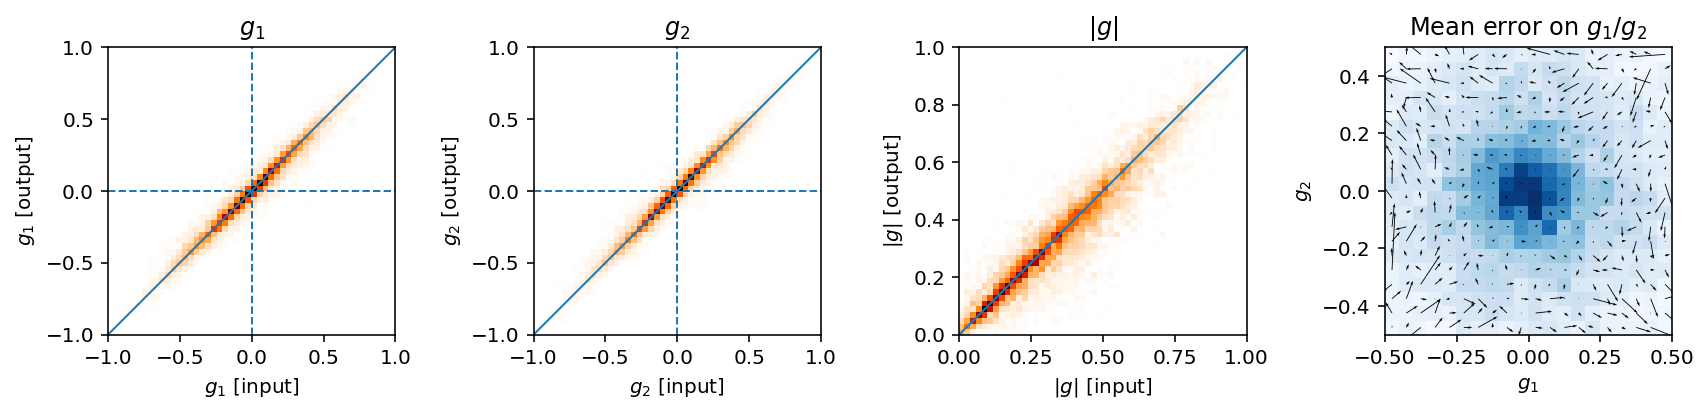

In [12]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst['e1_in'], df_lsst['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst['e2_in'], df_lsst['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst['e_in'], df_lsst['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,21)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst['e1_in'], df_lsst['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()
#plt.savefig('figures/ellipticities_lsst.pdf', dpi = 300)

|$g_1$|

In [27]:
# Linear regression
slope_lsst_1, intercept_lsst_1, r_value_lsst_1, p_value_lsst_1, std_err_lsst_1 = stats.linregress(df_lsst['e1_in'], df_lsst['e1_out'])

In [28]:
slope_lsst_1, intercept_lsst_1, r_value_lsst_1, p_value_lsst_1, std_err_lsst_1

(0.94923816914941,
 -0.0040635425363188815,
 0.9725622821346656,
 0.0,
 0.002270861039778413)

|$g_2$|

In [29]:
# Linear regression
slope_lsst_2, intercept_lsst_2, r_value_lsst_2, p_value_lsst_2, std_err_lsst_2 = stats.linregress(df_lsst['e2_in'], df_lsst['e2_out'])

In [30]:
slope_lsst_2, intercept_lsst_2, r_value_lsst_2, p_value_lsst_2, std_err_lsst_2

(0.9443000086025196,
 -0.0007172076337718321,
 0.9724374326081577,
 0.0,
 0.0022644003413696805)

|g|

In [47]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(df_lsst['e_in'], df_lsst['e_out'])

In [48]:
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst

(0.9252980578305586,
 0.016077447362693287,
 0.9437954872732495,
 0.0,
 0.003240843549989564)

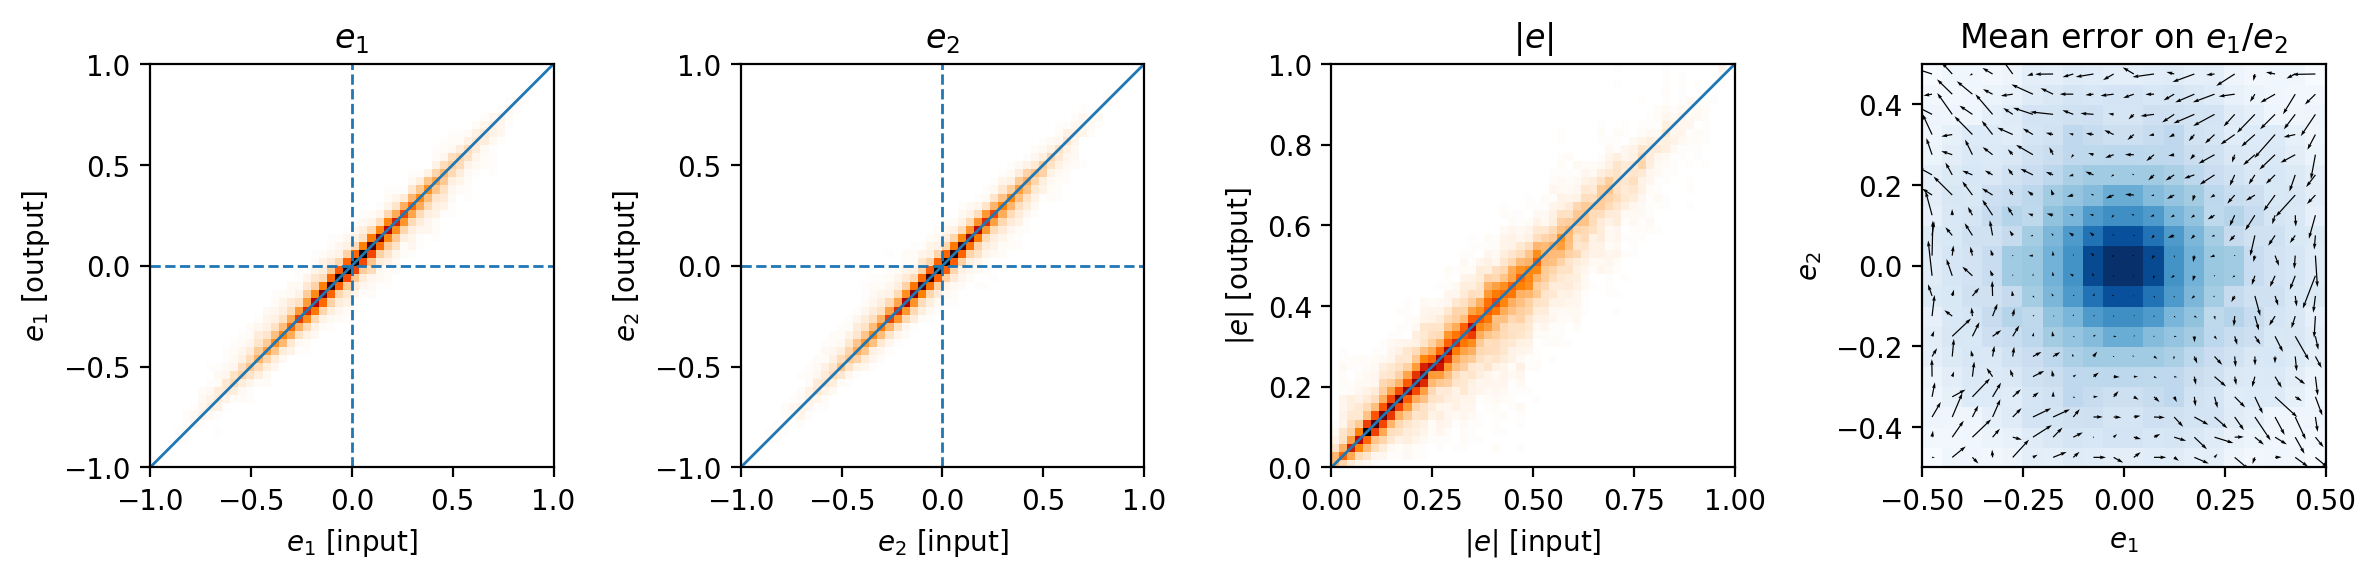

In [28]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst['e1_in'], df_lsst['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_1$ [input]')
ax.set_ylabel('$e_1$ [output]')
ax.set_title('$e_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst['e2_in'], df_lsst['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_2$ [input]')
ax.set_ylabel('$e_2$ [output]')
ax.set_title('$e_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst['e_in'], df_lsst['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|e|$ [input]')
ax.set_ylabel('$|e|$ [output]')
ax.set_title('$|e|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,21)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst['e1_in'], df_lsst['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$e_1$')
ax.set_ylabel('$e_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $e_1/e_2$')

plt.tight_layout()
plt.savefig('figures/ellipticities_lsst_v3.pdf', dpi = 300)

Text(0.5, 1.0, '$r$-band magnitude')

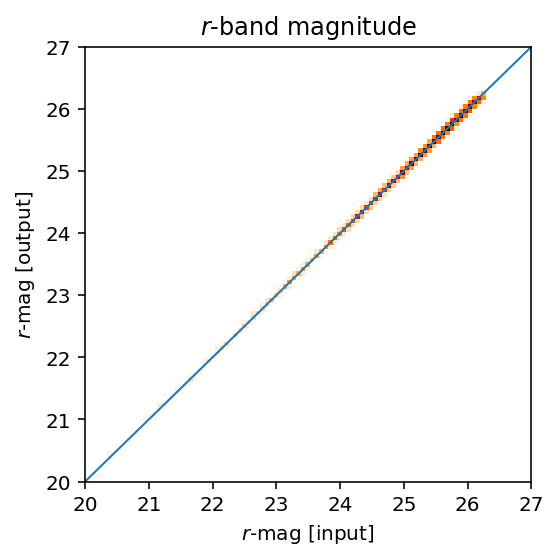

In [14]:
fig = plt.figure(figsize=(4,4))

emax = 100
bins = np.linspace(20,27,100)

#ax = fig.add_subplot(141, aspect='equal')
_ = plt.hist2d(df_lsst['mag_in'], df_lsst['mag_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax], lw=1)
plt.axhline(y=0, ls='--', lw=1)
plt.axvline(x=0, ls='--', lw=1)
plt.xlabel('$r$-mag [input]')
plt.ylabel('$r$-mag [output]')
plt.title('$r$-band magnitude')

#plt.tight_layout()


## LSST + Euclid all filters

Test VAE_processing for LSST and Euclid all band-pass filters

In [49]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [60]:
df_lsst_euclid = results_processing.processing(vae_lsst_euclid_conv,
                                                         data_dir,
                                                         root,
                                                         test_sample[0],
                                                         bands_lsst_euclid,
                                                         6,
                                                         stamp_size,  
                                                         batch_size,
                                                         PSF, 
                                                         pix_scale_lsst,
                                                         n_years)

0
1
2
3
4
error for galaxy 1663
error for galaxy 1963
5
6
7
8
9
10
11
error for galaxy 4596
error for galaxy 4796
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
error for galaxy 23437
59
60
61
62
63
64
65
error for galaxy 26001
66
67
68
69
70
71
72
error for galaxy 28840
error for galaxy 29040
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
error for galaxy 38077
96
97
98
99

(40000, 2, 2)


In [62]:
df_lsst_euclid.to_csv('data/df_vae_lsst_euclid_symetric.csv')

In [12]:
df_lsst_euclid.to_csv('data/df_vae_lsst_euclid.csv')

In [9]:
df_lsst_euclid = pd.read_csv('data/df_vae_lsst_euclid.csv', encoding = 'utf-8')

### Shape plots

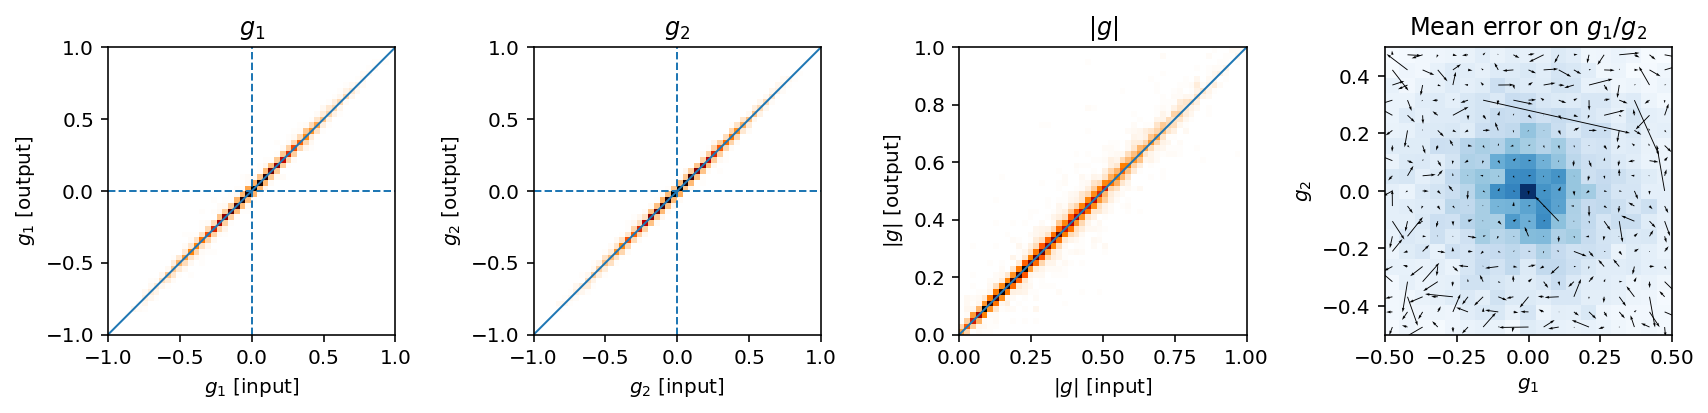

In [21]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))



# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

|$g_1$|

In [41]:
mask = ~np.isnan(df_lsst_euclid['e1_in']) & ~np.isnan(df_lsst_euclid['e1_out']) & ~(df_lsst_euclid['e1_in']>1)
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(df_lsst_euclid['e1_in'][mask], df_lsst_euclid['e1_out'][mask])

In [42]:
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid

(1.006865937503621,
 0.0007663991564284107,
 0.9864911512237204,
 0.0,
 0.0016733186676188543)

|$g_2$|

In [43]:
mask = ~np.isnan(df_lsst_euclid['e2_in']) & ~np.isnan(df_lsst_euclid['e2_out'])
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(df_lsst_euclid['e2_in'][mask], df_lsst_euclid['e2_out'][mask])

In [44]:
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid

(1.000916413170704,
 -0.0007678178544558413,
 0.9931037487554001,
 0.0,
 0.0011819660648173347)

|g|

In [45]:
mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(df_lsst_euclid['e_in'][mask], df_lsst_euclid['e_out'][mask])

In [46]:
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid

(0.9993252372765256,
 0.002717846368791188,
 0.9681536878409043,
 0.0,
 0.0025849488672435475)

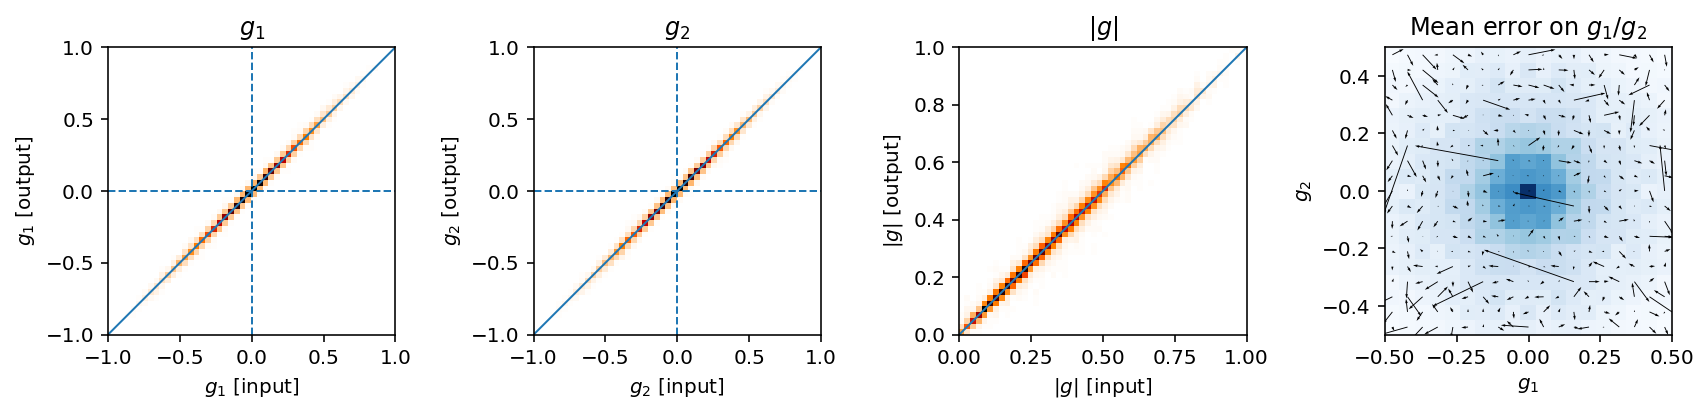

In [63]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))



# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

Text(0.5, 1.0, '$r$-band magnitude')

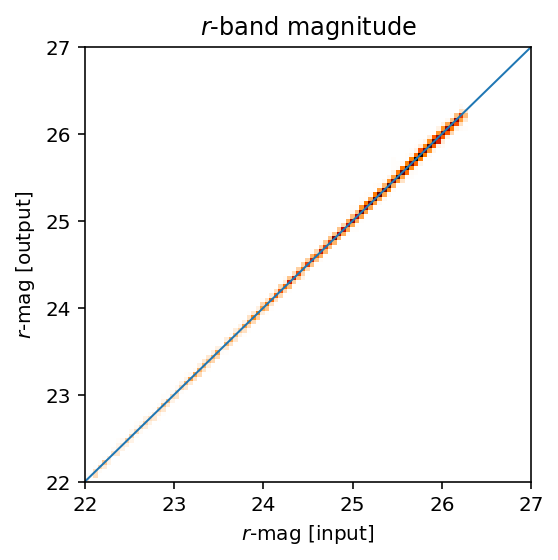

In [13]:
fig = plt.figure(figsize=(4,4))

emax = 100
bins = np.linspace(22,27,100)

#ax = fig.add_subplot(141, aspect='equal')
_ = plt.hist2d(df_lsst_euclid['mag_in'], df_lsst_euclid['mag_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax], lw=1)
plt.axhline(y=0, ls='--', lw=1)
plt.axvline(x=0, ls='--', lw=1)
plt.xlabel('$r$-mag [input]')
plt.ylabel('$r$-mag [output]')
plt.title('$r$-band magnitude')

#plt.tight_layout()


# Delta WL parameters

## As function of SNR

In [11]:
len(df_lsst)

10000

In [11]:
df_plot = pd.concat([df_lsst, df_lsst_euclid], ignore_index=True, sort = True)
df_plot['exp'] = [1]*10000 + [2]*10000

In [12]:
df_plot = df_plot.drop('Unnamed: 0', axis = 1)

In [13]:
df_plot = df_plot.dropna(axis = 1, how = 'all')

df_plot = df_plot[(df_plot['e1_out']<=1.) & 
                  (df_plot['e2_out']<=1.) &
                  (df_plot['e1_out']>=-1.) & 
                  (df_plot['e2_out']>=-1.) &
                  (df_plot['e_out']>=0.) & 
                  (df_plot['e_out']<=1.) ]

In [14]:
df_plot

,SNR,SNR_peak,delta_mag,e1,e1_error,e1_in,e1_out,e2,e2_error,e2_in,...,idx_closest_to_peak,mag,mag_in,mag_ir,mag_out,moment_sigma,n_peak_detected,nb_blended_gal,redshift,exp
0,1048.061796,0.510847,-0.035474,0.429479,0.011435,0.429479,0.440914,-0.537024,-0.009910,-0.537024,...,0,23.090091,21.341064,-3.730106,21.305590,3.345970,1,1,0.306800,1
1,60.969725,0.036068,-0.012638,-0.121809,-0.003531,-0.121809,-0.125340,0.077567,0.019422,0.077567,...,0,26.868364,25.119150,-1.418402,25.106512,2.175268,1,1,1.611300,1
2,330.892748,0.251758,0.029153,0.505695,-0.044572,0.505695,0.461123,-0.147924,0.023566,-0.147924,...,0,25.104066,23.354850,-1.679262,23.384003,1.823595,1,1,0.262900,1
3,79.629374,0.051692,0.019380,0.495612,0.031653,0.495612,0.527265,-0.493724,-0.015913,-0.493724,...,0,26.530549,24.781329,-1.657671,24.800709,2.100793,1,1,0.829100,1
4,58.045023,0.041426,-0.041574,0.245750,0.010564,0.245750,0.256314,-0.179226,0.019732,-0.179226,...,0,27.089047,25.339828,-1.122494,25.298254,1.808643,1,1,1.230700,1
5,27.329735,0.018280,-0.072090,-0.220152,-0.049443,-0.220152,-0.269596,0.173139,0.017466,0.173139,...,0,27.735093,25.986000,-2.681113,25.913910,2.005610,1,1,3.011100,1
6,109.613943,0.056629,-0.030227,0.036942,-0.021085,0.036942,0.015858,-0.170857,0.008835,-0.170857,...,0,26.089858,24.340646,-2.123240,24.310420,2.508874,1,1,1.233400,1
7,36.762999,0.028052,-0.066764,-0.085118,-0.078884,-0.085118,-0.164003,-0.145654,0.149607,-0.145654,...,0,27.639563,25.890347,-1.470141,25.823584,1.676499,1,1,2.681600,1
8,82.486982,0.044829,-0.007550,0.118835,-0.006167,0.118835,0.112668,0.011297,-0.001936,0.011297,...,0,26.387324,24.638134,-1.823402,24.630585,2.462739,1,1,1.229300,1
9,68.881903,0.037439,0.007561,0.678211,-0.017885,0.678211,0.660326,-0.151220,0.018882,-0.151220,...,0,26.330661,24.582040,-2.290791,24.589602,2.654459,1,1,0.985900,1


19817
[1 2]
0 1
1 2


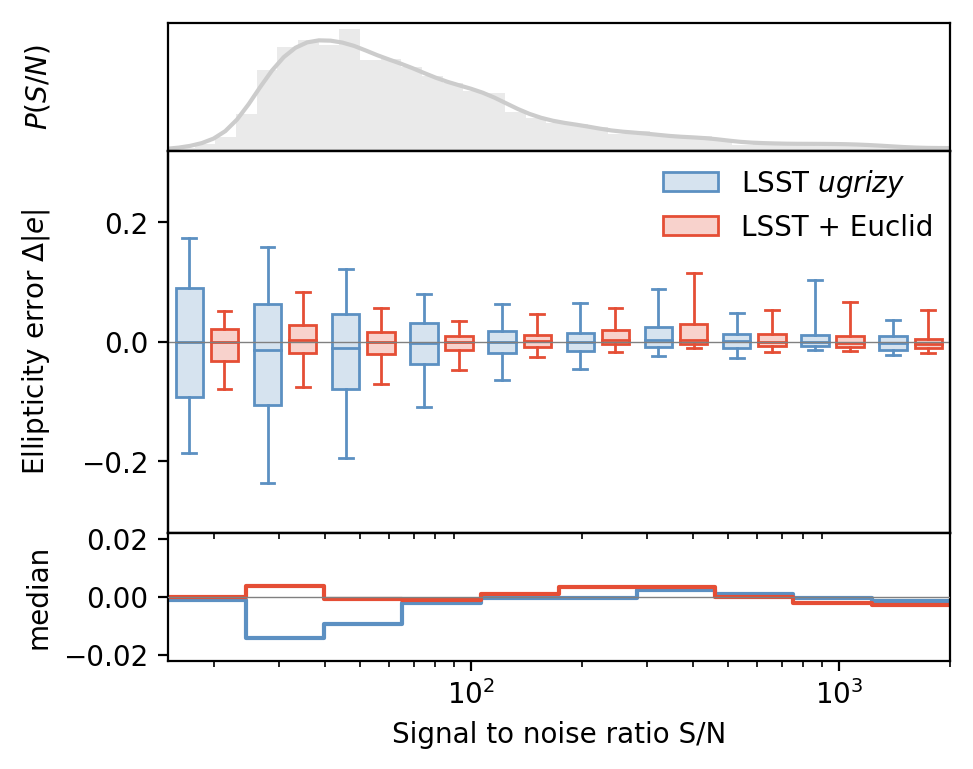

In [16]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (15, 2000),
              ylim = (-0.32, 0.32), 
              ylim2 = (-0.022, 0.022), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)


fig.savefig('figures/e_vae_snr_3.pdf')

19817
[1 2]
0 1
1 2


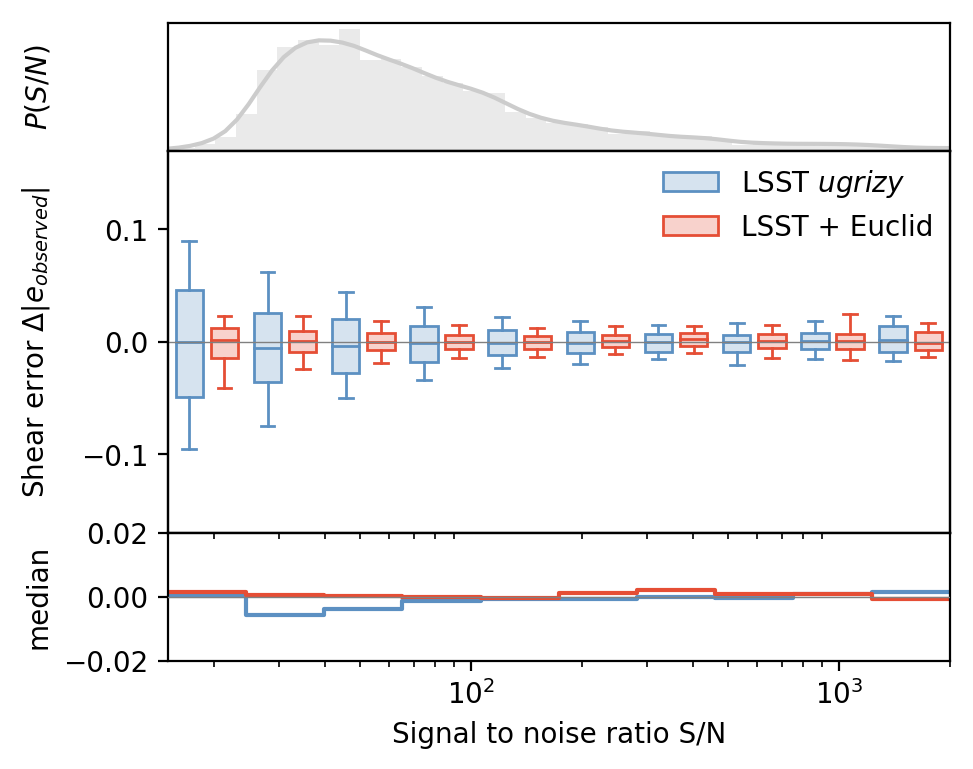

In [77]:
fig, median_shear_2, q1_shear_2, q3_shear_2, whislo_shear_2, whishi_shear_2 = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_obs_error', z = 'exp',
              xlim = (15, 2000),
              ylim = (-0.17, 0.17), 
              ylim2 = (-0.02, 0.02), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |e_{observed}|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/e_vae_snr_2.pdf')

19817
[1 2]
0 1
1 2


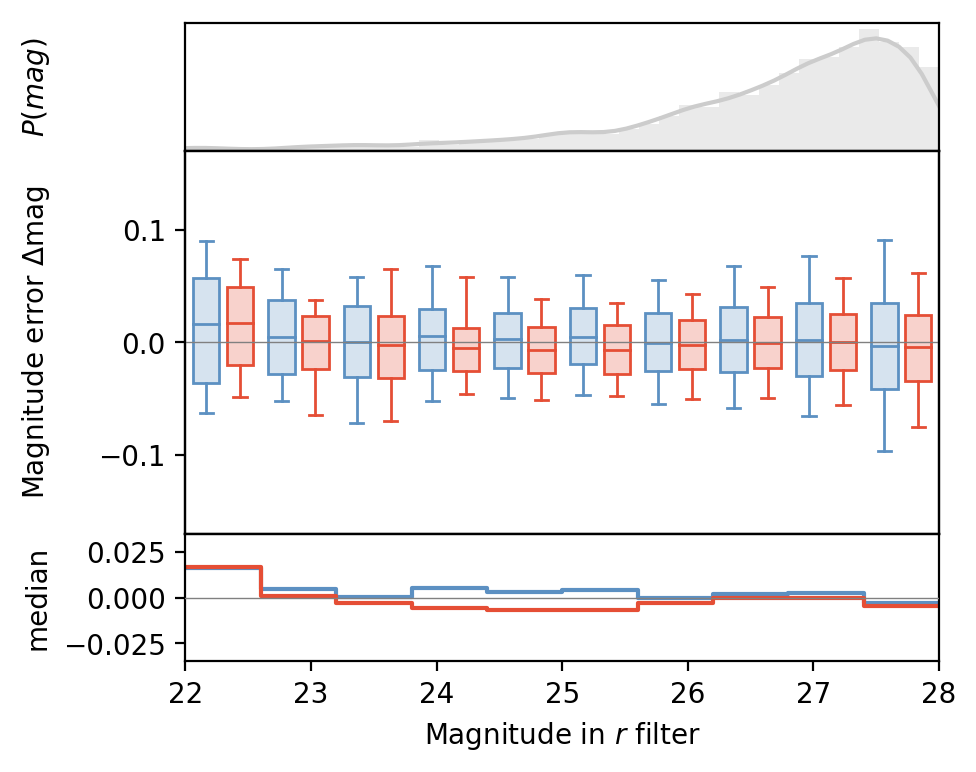

In [78]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, 
              x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (22, 28),
              ylim = (-0.17, 0.17),
              ylim2 = (-0.035, 0.035),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Magnitude in $r$ filter', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

fig.savefig('figures/mag_mag_vae_3.pdf')

In [81]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = np.abs(median_shear)
df_stat['q1_shear'] = np.abs(q1_shear)
df_stat['q3_shear'] = np.abs(q3_shear)
df_stat['whislo_shear'] = np.abs(whislo_shear)
df_stat['whishi_shear'] = np.abs(whishi_shear)
df_stat['median_mag'] = np.abs(median_mag)
df_stat['q1_mag'] = np.abs(q1_mag)
df_stat['q3_mag'] = np.abs(q3_mag)
df_stat['whislo_mag'] = np.abs(whislo_mag)
df_stat['whishi_mag'] = np.abs(whishi_mag)
df_stat['stats_names'] = ['LSST']*10 + ['LSST Euclid']*10

x = 10

In [ ]:
x = 0 # for the first x bins

In [ ]:
df_stat

In [93]:
param = 'median_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.006723038031857448, 0.0013207458166888328, nan]
improvement between each exp: [5.090334526829997, nan]


In [94]:
param = 'q1_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.07842506746231385, 0.021318507793163514, nan]
improvement between each exp: [3.678731561477462, nan]


In [95]:
param = 'q3_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.05782768281296878, 0.01944967113460481, nan]
improvement between each exp: [2.973195917440573, nan]


In [96]:
param = 'whislo_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.18171903201646736, 0.06827966126117362, nan]
improvement between each exp: [2.6613932854965645, nan]


In [97]:
param = 'whishi_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.13377519459277964, 0.05691142025858763, nan]
improvement between each exp: [2.350586121115009, nan]


In [87]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.004144771992082674, 0.004764568600525187, nan]
improvement between each exp: [0.869915482301127, nan]


In [88]:
param = 'q1_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.028586547669592916, 0.02609030107575867, nan]
improvement between each exp: [1.095677186192136, nan]


In [89]:
param = 'q3_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.03392871076905462, 0.02273549719331941, nan]
improvement between each exp: [1.4923232371194513, nan]


In [90]:
param = 'whislo_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.06119194195417101, 0.05588736921532096, nan]
improvement between each exp: [1.0949154131484125, nan]


In [91]:
param = 'whishi_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.06888916342958887, 0.051835125263807666, nan]
improvement between each exp: [1.3290054394387405, nan]


## Shear Bias 

As function of SNR

In [32]:
df_bias = pd.DataFrame()
param = 'SNR'
#df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & (df_lsst_euclid['e2_out']<=1.)]

bins = np.geomspace(30, 3000, 10)

for k in range (2):
    slope = []
    intercept = []
    std_err = []
    bins_list = []

    bining_temp = 10
    mask = ~np.isnan(df_lsst['e_in']) & ~np.isnan(df_lsst['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst[(df_lsst['e1_out']<=1.) & 
                          (df_lsst['e2_out']<=1.) &
                          (df_lsst['e_out']<=1.) & 
                          (df_lsst['e_out']>=0.) &
                          (bining_temp <= df_lsst[param]) &
                          (df_lsst[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)#-(bins[0]/2)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & 
                                 (df_lsst_euclid['e2_out']<=1.) &
                                 (df_lsst_euclid['e_out']<=1.) & 
                                 (df_lsst_euclid['e_out']>=0.) &
                                 (bining_temp <= df_lsst_euclid[param]) &
                                 (df_lsst_euclid[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)#-(bins[0]/2)
        bining_temp = bining

    df_bias['slope_e'+str(k+1)] = np.array(slope)
    df_bias['intercept_e'+str(k+1)] = np.array(intercept)
    df_bias['std_err_e'+str(k+1)] = np.array(std_err)

In [33]:
list_mid_bins = []
idx_temp = 10
for i, idx in enumerate (bins_list):
    if i == 10:
        idx_temp = 10
    list_mid_bins.append(idx - (idx - idx_temp)/2)
    idx_temp = idx

In [34]:
list_mid_bins, bins_list, 

([20.0,
  40.02150805800087,
  66.75989909110773,
  111.36222353729855,
  185.76338490636067,
  309.87200215440146,
  516.897653257015,
  862.2372530754765,
  1438.2984250491058,
  2399.2263754784126,
  20.0,
  40.02150805800087,
  66.75989909110773,
  111.36222353729855,
  185.76338490636067,
  309.87200215440146,
  516.897653257015,
  862.2372530754765,
  1438.2984250491058,
  2399.2263754784126],
 [29.999999999999996,
  50.043016116001745,
  83.47678206621372,
  139.24766500838336,
  232.27910480433795,
  387.46489950446494,
  646.330407009565,
  1078.144099141388,
  1798.4527509568234,
  3000.0000000000014,
  29.999999999999996,
  50.043016116001745,
  83.47678206621372,
  139.24766500838336,
  232.27910480433795,
  387.46489950446494,
  646.330407009565,
  1078.144099141388,
  1798.4527509568234,
  3000.0000000000014])

In [35]:
df_bias['Experience'] = len(bins)*['LSST'] + len(bins)*['LSST+Euclid']
df_bias['bins_list'] = list_mid_bins
df_bias['mean_g'] = np.mean([df_bias['slope_e1'],df_bias['slope_e2']], axis = 0)
df_bias['mean_stderr'] = np.mean([df_bias['std_err_e1'],df_bias['std_err_e2']], axis = 0)

In [36]:
df_bias

,slope_e1,intercept_e1,std_err_e1,slope_e2,intercept_e2,std_err_e2,Experience,bins_list,mean_g,mean_stderr
0,-0.079095,-0.002298,0.009469,-0.081169,-0.002051,0.008904,LSST,20.000000,-0.080132,0.009187
1,-0.088089,-0.006394,0.005128,-0.102737,-0.002379,0.005194,LSST,40.021508,-0.095413,0.005161
2,-0.054146,-0.004947,0.004093,-0.048483,0.000626,0.004102,LSST,66.759899,-0.051314,0.004097
3,-0.013963,-0.002313,0.003504,-0.013152,0.000280,0.003308,LSST,111.362224,-0.013557,0.003406
4,-0.005407,-0.003132,0.003232,-0.004137,0.000436,0.002655,LSST,185.763385,-0.004772,0.002944
5,0.017797,-0.001864,0.003799,0.018052,-0.003554,0.004771,LSST,309.872002,0.017924,0.004285
6,0.023035,-0.000029,0.003709,0.022196,-0.000352,0.003979,LSST,516.897653,0.022616,0.003844
7,0.016734,0.000625,0.004847,0.025075,0.000237,0.006244,LSST,862.237253,0.020905,0.005545
8,0.005022,0.001013,0.005533,0.017028,0.000076,0.004876,LSST,1438.298425,0.011025,0.005205
9,-0.016755,0.002083,0.013373,-0.032069,0.002991,0.013690,LSST,2399.226375,-0.024412,0.013532


["['LSST $|g_1|$', 'LSST+Euclid $|g_1|$']", 'Experience', 'LSST', 'LSST+Euclid']
["['LSST $|g_2|$', 'LSST+Euclid $|g_2|$']", 'Experience', 'LSST', 'LSST+Euclid']
['Experience', 'LSST', 'LSST+Euclid']


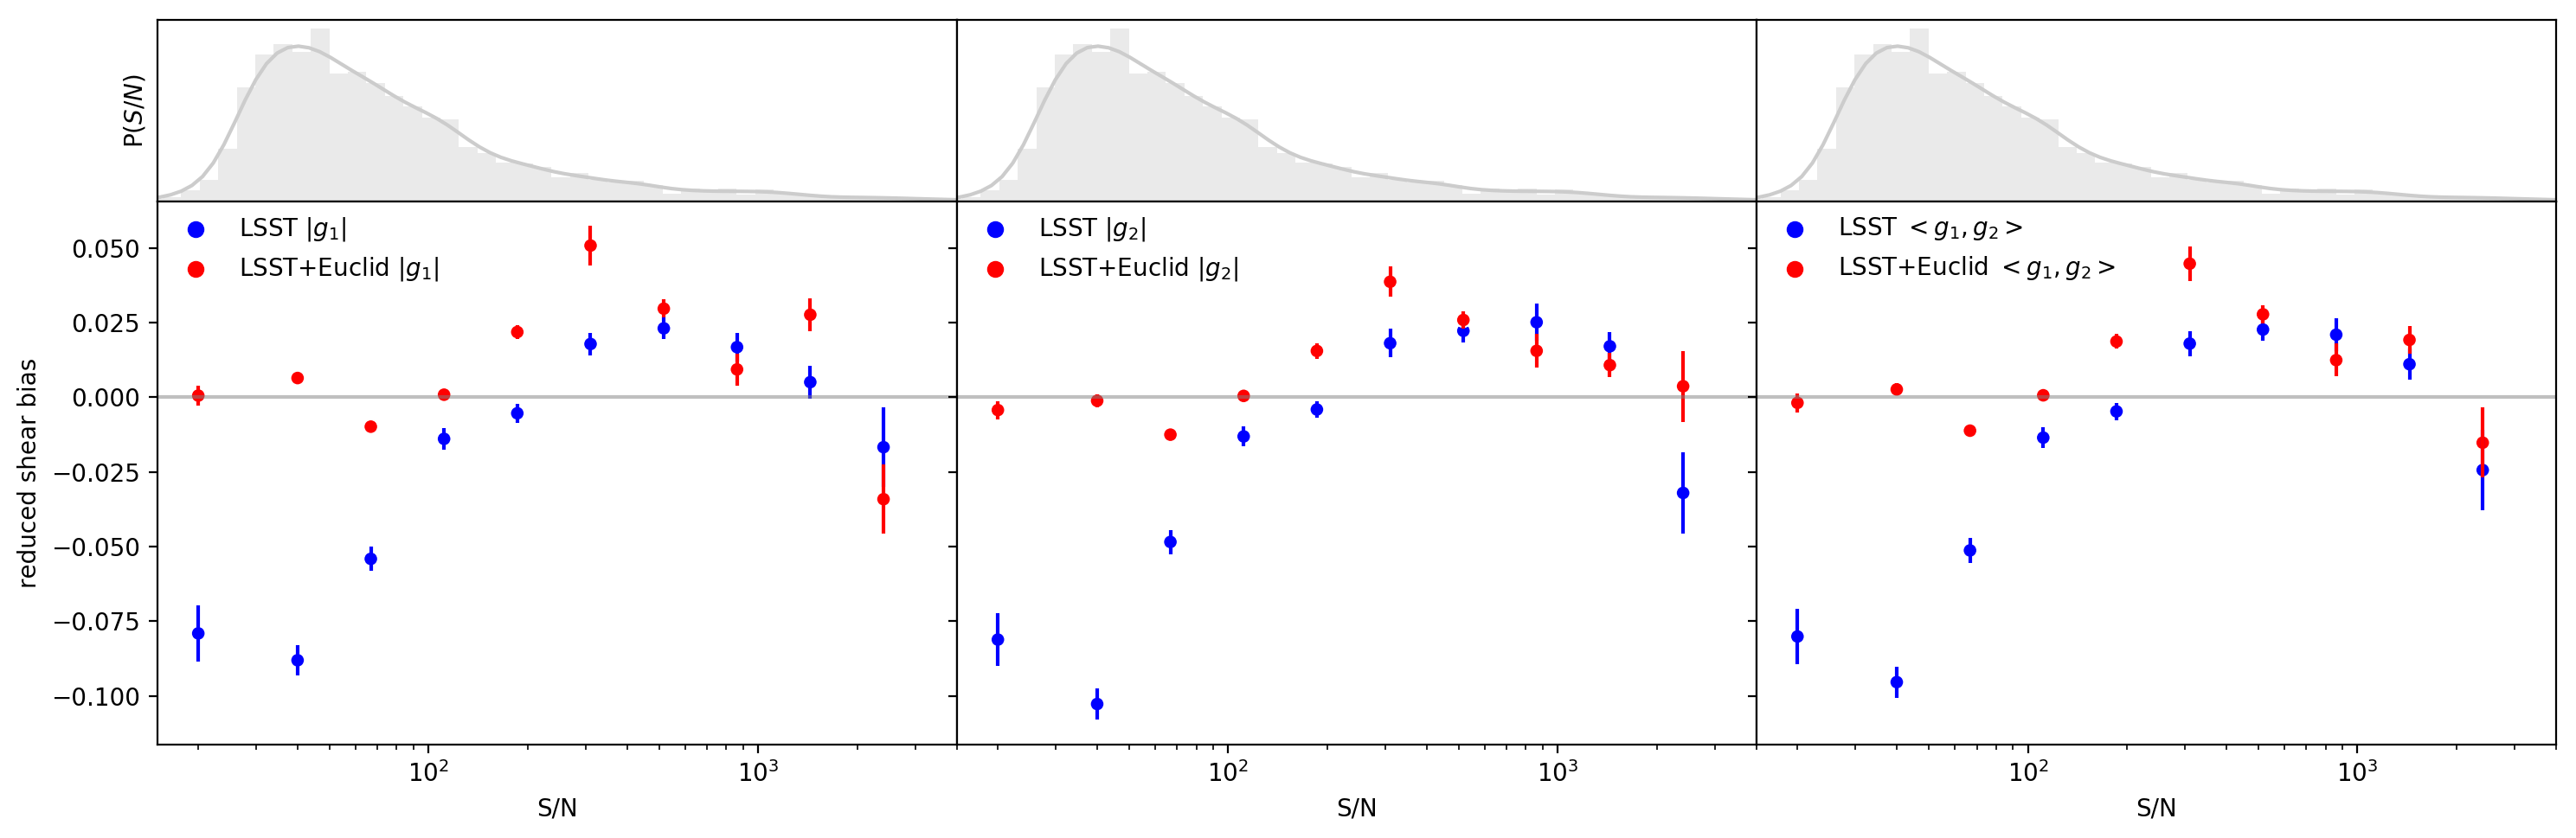

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(15,5),sharey='row', gridspec_kw={'height_ratios': [1, 3]})

palette_lsst = ['blue']
palette_lsst_euclid = ['red']

xlim = (15,4000)
xscale = 'log'

for i in range (3):
    sns.distplot(np.log10(df_lsst[param]), ax=axes[0,i], color='0.8')
    axes[0,i].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
axes[0,0].set_ylabel('P($S/N$)')
axes[0,0].set_yticks([])

for k in range (2):
    handles = []
    legend = []

    axis = axes[1,k]
    ax = sns.scatterplot(x="bins_list",
                  y="slope_e"+str(k+1), 
                  hue="Experience",
                  data=df_bias, 
                  markers = '.',
                  palette = [palette_lsst[0], palette_lsst_euclid[0]],
                  label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
                  ax = axis)
    print(ax.get_legend_handles_labels()[1])

    handles.append(ax.get_legend_handles_labels()[0][2])
    handles.append(ax.get_legend_handles_labels()[0][3])
    legend.append('LSST $|g_'+str(k+1)+'|$')
    legend.append('LSST+Euclid $|g_'+str(k+1)+'|$')
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []

    for i, idx in enumerate (df_bias['bins_list']):
        x_coords.append(idx)
        y_coords.append(df_bias["slope_e"+str(k+1)][i])

    colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/2) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/2)

    axis.errorbar(x_coords, 
                 y_coords, 
                 yerr=df_bias['std_err_e'+str(k+1)],
                 ecolor=colors,
                 fmt=' ')


    axis.legend(handles, legend, frameon=False, loc ='upper left', borderpad = 0.1, fontsize = 10)
    axis.set_xlabel('S/N')
    axis.set_ylabel('reduced shear bias')
    axis.axhline(0,color = 'grey', alpha = 0.5)
    axis.set_xscale(xscale)
    axis.set_xlim(xlim)

 

handles = []
legend = []

axis = axes[1,2]
ax = sns.scatterplot(x="bins_list",
              y="mean_g", 
              hue="Experience",
              data=df_bias, 
              markers = '.',
              palette = [palette_lsst[0], palette_lsst_euclid[0]],
              #label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
              ax = axis)
print(ax.get_legend_handles_labels()[1])

handles.append(ax.get_legend_handles_labels()[0][1])
handles.append(ax.get_legend_handles_labels()[0][2])
legend.append('LSST $<g_1, g_2>$')
legend.append('LSST+Euclid $<g_1, g_2>$')
# Find the x,y coordinates for each point
x_coords = []
y_coords = []

for i, idx in enumerate (df_bias['bins_list']):
    x_coords.append(idx)
    y_coords.append(df_bias["mean_g"][i])

colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/2) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/2)

axis.errorbar(x_coords, 
             y_coords, 
             yerr=df_bias['mean_stderr'],
             ecolor=colors,
             fmt=' ')


axis.legend(handles, legend, frameon=False, loc ='upper left', borderpad = 0.1, fontsize = 10)#, colors = ['steelblue','coral','blue','red'])
axis.set_xlabel('S/N')
axis.axhline(0, color = 'grey', alpha = 0.5)
axis.set_xscale(xscale)
axis.set_xlim(xlim)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)